In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import random
import numpy

<IPython.core.display.Javascript object>

In [3]:
def flip():
    return 1 if random.random() < 0.5 else 0


def generate():
    return random.triangular(0, 1, 1)


def prepare_for_XGBoost(X, y):
    return xgb.DMatrix(X, label=y)


from sklearn.metrics import confusion_matrix


def predict_with_XGBoost(model, dX, y):
    temp = model.predict(dX)
    return [round(x) for x in temp]


def predict_with_XGBoost_and_return_Confusion_Matrix(model, dX, y):
    temp = model.predict(dX)
    temp = [round(x) for x in temp]
    return confusion_matrix(y, temp)

<IPython.core.display.Javascript object>

(array([ 18.,  83., 128., 167., 239., 304., 331., 383., 389., 458.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 <a list of 11 Patch objects>)

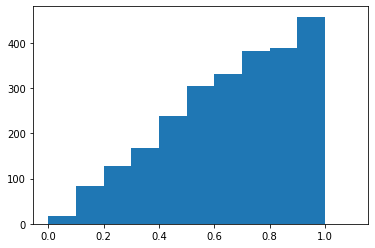

<IPython.core.display.Javascript object>

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
bins = [0.1 * i for i in range(12)]
plt.hist([random.triangular(0, 1, 1) for i in range(2500)], bins)

In [5]:
m = 1000000
good_features = 5
bad_features = 5
n = good_features + bad_features
good = 0
bad = 1
X = numpy.zeros((m, n))
y = numpy.zeros((m))
for i in range(m):
    vec = numpy.zeros((n))
    y[i] = flip()
    if y[i] == good:
        for j in range(good_features):
            vec[j] = generate()
        for j in range(bad_features):
            vec[j + good_features] = 1 - generate()
    else:
        for j in range(good_features):
            vec[j] = 1 - generate()
        for j in range(bad_features):
            vec[j + good_features] = generate()
    X[i, :] = vec

<IPython.core.display.Javascript object>

In [6]:
print(X[:5])
print(y[:5])

[[0.80532567 0.92490839 0.76229776 0.21723793 0.89442271 0.2533954
  0.17035758 0.60755975 0.40627205 0.34162412]
 [0.6078555  0.1749582  0.66225547 0.03092389 0.47605521 0.71063285
  0.88470052 0.84199926 0.12980379 0.73148675]
 [0.75421467 0.35859618 0.97344397 0.62061552 0.61107118 0.46083668
  0.52475708 0.17564278 0.0588624  0.23044161]
 [0.31115242 0.13372737 0.23298339 0.09242849 0.15353954 0.24079295
  0.53004054 0.49740195 0.79480049 0.16365336]
 [0.75995086 0.3056331  0.28099494 0.19333433 0.38890581 0.92336874
  0.8352815  0.67782679 0.9229689  0.67621793]]
[0. 1. 0. 1. 1.]


<IPython.core.display.Javascript object>

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [8]:
import xgboost as xgb

dtrain = prepare_for_XGBoost(X_train, y_train)
dtest = prepare_for_XGBoost(X_test, y_test)
dall = prepare_for_XGBoost(X, y)

<IPython.core.display.Javascript object>

In [9]:
from sklearn.metrics import confusion_matrix

params = {
    "n_jobs": 1,
}
model_no_constraints = xgb.train(params=params, dtrain=dtrain)
print(
    predict_with_XGBoost_and_return_Confusion_Matrix(
        model_no_constraints, dtrain, y_train
    )
)
print()
print(
    predict_with_XGBoost_and_return_Confusion_Matrix(
        model_no_constraints, dtest, y_test
    )
)
model_no_constraints = xgb.train(params=params, dtrain=dall)

[[390647   8934]
 [  8886 391533]]

[[97579  2451]
 [ 2362 97608]]


<IPython.core.display.Javascript object>

In [10]:
params_constrained = params.copy()
monotone_constraints = (
    "("
    + ",".join([str(0) for m in range(good_features)])
    + ","
    + ",".join([str(1) for m in range(bad_features)])
    + ")"
)
params_constrained["monotone_constraints"] = monotone_constraints
model_monotonic = xgb.train(params=params_constrained, dtrain=dtrain)
print(
    predict_with_XGBoost_and_return_Confusion_Matrix(model_monotonic, dtrain, y_train)
)
print()
print(predict_with_XGBoost_and_return_Confusion_Matrix(model_monotonic, dtest, y_test))
model_monotonic = xgb.train(params=params_constrained, dtrain=dall)

[[390695   8886]
 [  9305 391114]]

[[97628  2402]
 [ 2420 97550]]


<IPython.core.display.Javascript object>

In [11]:
X_bad = X[y == bad]
y_bad = len(X_bad) * [1]
dX_bad = prepare_for_XGBoost(X_bad, y_bad)
sum(predict_with_XGBoost(model_no_constraints, dX_bad, y_bad))

489391.0

<IPython.core.display.Javascript object>

In [12]:
X_adversarial = X[y == bad]
y_adversarial = numpy.ones((len(X_adversarial)))
for i in range(len(X_adversarial)):
    vec = X_adversarial[i, :]
    for j in range(good_features):
        vec[j] = 1
    X_adversarial[i, :] = vec

<IPython.core.display.Javascript object>

In [13]:
data = X_adversarial
label = y_adversarial
dadv = xgb.DMatrix(data, label=label)

<IPython.core.display.Javascript object>

In [14]:
bla = model_monotonic.predict(dadv)
blu = [round(x) for x in bla]
confusion_matrix(y_adversarial, blu)

array([[     0,      0],
       [400299, 100090]], dtype=int64)

<IPython.core.display.Javascript object>

In [15]:
bla = model_no_constraints.predict(dadv)
blu = [round(x) for x in bla]
confusion_matrix(y_adversarial, blu)

array([[     0,      0],
       [494949,   5440]], dtype=int64)

<IPython.core.display.Javascript object>